### Experiments for the paper:

# The Sparse + Low Rank trick for Matrix Factorization-Based Graph Algorithms

In [2]:
import numpy as np
import pandas as pd
import pickle
from scipy import sparse
from time import time

from datasets import Dataset, BDataset
from randomized_matrix_factorization import SparseLR, randomized_eig, randomized_svd

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

### Datasets

In [4]:
undirected_graphs = pd.read_csv('undirected.csv')
undirected_graphs

,Code,Name,Filename,n_nodes,n_edges
0,MK,Kangaroo,moreno_kangaroo,17.0,182.0
1,JZ,Jazz musicians,arenas-jazz,198.0,5484.0
2,Shf,Hamsterster friendships,petster-friendships-hamster,1788.0,24952.0
3,RC,Reactome,reactome,5973.0,292770.0
4,GW,Gowalla,loc-gowalla_edges,196591.0,1900654.0
5,SK,Skitter,as-skitter,1694616.0,22188418.0
6,OR,Orkut,orkut-links,3072441.0,234369798.0


In [5]:
bipartite_graphs = pd.read_csv('bipartite.csv')
bipartite_graphs

,Code,Name,Filename,n1,n2,n_edges
0,SW,Southern women 1,opsahl-southernwomen,18.0,14.0,89.0
1,UL,Unicode languages,unicodelang,248.0,610.0,1249.0
2,SX,Sexual escorts,escorts,9652.0,6158.0,38540.0
3,Mut,MovieLens user–tag,movielens-10m_ut,3654.0,16015.0,43228.0
4,R2,Reuters-21578,gottron-reuters,19757.0,38677.0,978446.0
5,M3,MovieLens 10M,movielens-10m_rating,69878.0,10677.0,10000054.0
6,RE,Reuters,reuters,781265.0,283911.0,60569726.0


### Modularity Factorization

In [5]:
def modularity_matrix(adj_matrix, dense=False):
    total_weight = adj_matrix.data.sum()
    pou = adj_matrix.dot(np.ones(adj_matrix.shape[1])) / total_weight
    pin = adj_matrix.T.dot(np.ones(adj_matrix.shape[0])) / total_weight
    
    if dense:
        return adj_matrix.toarray() / total_weight - pou[:, np.newaxis].dot(pin[:, np.newaxis].T)
    else:
        return SparseLR(adj_matrix / total_weight, [(-pou, pin)])

In [6]:
def benchmark_halko(graph, n_components):
    if type(graph) == Dataset:
        decomposition = randomized_eig
    else:
        decomposition = randomized_svd
        
    modularity = modularity_matrix(graph.adj_matrix, dense=False)
    t0 = time()
    decomposition(modularity, n_components)
    t1 = time()
    
    return t1 - t0

In [7]:
def benchmark_lanczos(graph, n_components):
    if type(graph) == Dataset:
        decomposition = sparse.linalg.eigsh
    else:
        decomposition = sparse.linalg.svds
        
    modularity = modularity_matrix(graph.adj_matrix, dense=True)
    t0 = time()
    decomposition(modularity, n_components)
    t1 = time()
    
    return t1 - t0

### Runs

#### Experiment 1: Fixed number of components, different graphs

In [8]:
n_components = 16

In [9]:
exp1 = {'undirected': {'sparse+low_rank': {}, 'dense': {}},
           'bipartite': {'sparse+low_rank': {}, 'dense': {}}
         }

In [10]:
for i, filename in enumerate(undirected_graphs['Filename']):
    graph = Dataset(filename)
    
    exp1['undirected']['sparse+low_rank'][i] = benchmark_halko(graph, n_components)
    
    try:
        exp1['undirected']['dense'][i] = benchmark_lanczos(graph, n_components)
    except MemoryError:
        pass

In [11]:
for i, filename in enumerate(bipartite_graphs['Filename']):
    graph = BDataset(filename)
    
    exp1['bipartite']['sparse+low_rank'][i] = benchmark_halko(graph, n_components)
    
    try:
        k = min(n_components, min(graph.adj_matrix.shape) - 1)
        exp1['bipartite']['dense'][i] = benchmark_lanczos(graph, k)
    except MemoryError:
        pass

In [20]:
pickle.dump(exp1, open('exp1.p', 'bw'))

#### Experiment 2: Fixed graphs, varying number of components

In [43]:
all_n_components = [8, 16, 32, 64, 128, 264]

In [44]:
exp2 = {'undirected': {'sparse+low_rank': {}, 'dense': {}},
        'bipartite': {'sparse+low_rank': {}, 'dense': {}}
         }

In [45]:
reactome = Dataset('reactome')
movielens = BDataset('movielens-10m_ut')

In [46]:
for k in all_n_components:
    exp2['undirected']['sparse+low_rank'][k] = benchmark_halko(reactome, k)
    exp2['undirected']['dense'][k] = benchmark_lanczos(reactome, k)
    
    exp2['bipartite']['sparse+low_rank'][k] = benchmark_halko(movielens, k)
    exp2['bipartite']['dense'][k] = benchmark_lanczos(movielens, k)

In [48]:
pickle.dump(exp2, open('exp2.p', 'wb'))

## Display of the results

### Experiment 1

In [3]:
exp1 = pickle.load(open('exp1.p', 'rb'))

#### Undirected Graphs

In [8]:
x = undirected_graphs['n_edges'].values
y_slr = [exp1['undirected']['sparse+low_rank'][key] for key in exp1['undirected']['sparse+low_rank']]
y_dns = [exp1['undirected']['dense'][key] for key in exp1['undirected']['dense']]

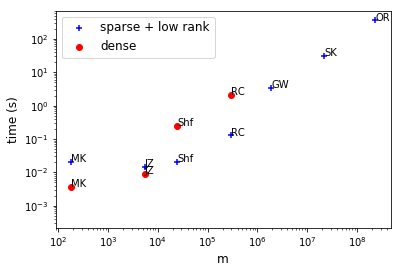

In [13]:
plt.figure()
plt.scatter(x, y_slr, c='b', marker='+', label='sparse + low rank')
plt.scatter(x[:len(y_dns)], y_dns, c='r', marker='o', label='dense')

for i in range(len(y_slr)):
    plt.annotate(undirected_graphs.at[i, 'Code'], (x[i], y_slr[i]))
for i in range(len(y_dns)):
    plt.annotate(undirected_graphs.at[i, 'Code'], (x[i], y_dns[i]))

plt.loglog()
plt.xlabel('m', fontsize='large')
plt.ylabel('time (s)', fontsize='large')
plt.legend(fontsize='large')

plt.savefig('scatter_undirected.pdf', transparent=True, format='pdf')
plt.show()

#### Bipartite Graphs

In [16]:
x = bipartite_graphs['n_edges'].values
y_slr = [exp1['bipartite']['sparse+low_rank'][key] for key in exp1['bipartite']['sparse+low_rank']]
y_dns = [exp1['bipartite']['dense'][key] for key in exp1['bipartite']['dense']]

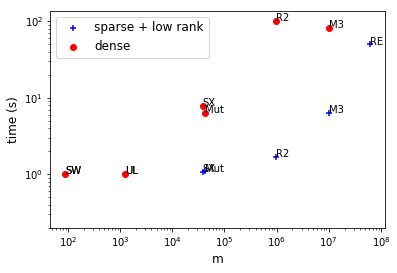

In [18]:
plt.figure()
plt.scatter(x, 1 + np.array(y_slr), c='b', marker='+', label='sparse + low rank')
plt.scatter(x[:len(y_dns)], 1 + np.array(y_dns), c='r', marker='o', label='dense')

for i in range(len(y_slr)):
    plt.annotate(bipartite_graphs.at[i, 'Code'], (x[i], 1 + y_slr[i]))
for i in range(len(y_dns)):
    plt.annotate(bipartite_graphs.at[i, 'Code'], (x[i], 1 + y_dns[i]))

plt.loglog()
plt.xlabel('m', fontsize='large')
plt.ylabel('time (s)', fontsize='large')
plt.legend(fontsize='large')

plt.savefig('scatter_bipartite.pdf', transparent=True, format='pdf')
plt.show()

### Experiment 2
#### Reactome

In [57]:
x = all_n_components
y_slr = [exp2['undirected']['sparse+low_rank'][key] for key in exp2['undirected']['sparse+low_rank']]
y_dns = [exp2['undirected']['dense'][key] for key in exp2['undirected']['dense']]

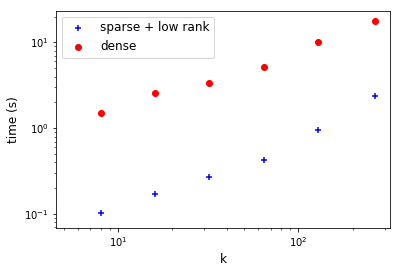

In [58]:
plt.figure()
plt.scatter(x, y_slr, c='b', marker='+', label='sparse + low rank')
plt.scatter(x[:len(y_dns)], y_dns, c='r', marker='o', label='dense')

plt.loglog()
plt.xlabel('k', fontsize='large')
plt.ylabel('time (s)', fontsize='large')
plt.legend(fontsize='large')

plt.savefig('scatter_reactome.pdf', transparent=True, format='pdf')
plt.show()

#### Movielens

In [59]:
x = all_n_components
y_slr = [exp2['bipartite']['sparse+low_rank'][key] for key in exp2['bipartite']['sparse+low_rank']]
y_dns = [exp2['bipartite']['dense'][key] for key in exp2['bipartite']['dense']]

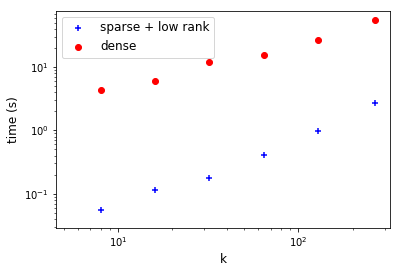

In [60]:
plt.figure()
plt.scatter(x, y_slr, c='b', marker='+', label='sparse + low rank')
plt.scatter(x[:len(y_dns)], y_dns, c='r', marker='o', label='dense')

plt.loglog()
plt.xlabel('k', fontsize='large')
plt.ylabel('time (s)', fontsize='large')
plt.legend(fontsize='large')

plt.savefig('scatter_movielens.pdf', transparent=True, format='pdf')
plt.show()